In [10]:
import lettuce as lt
import matplotlib.pyplot as plt
import numpy as np
import torch
import os
import csv
from argparse import ArgumentParser, ArgumentDefaultsHelpFormatter

In [11]:
parser = ArgumentParser(formatter_class=ArgumentDefaultsHelpFormatter)
parser.add_argument("--vtkdir", type=str, help="name base of vtk files - they are usually in a vtk-subdirectory!", default="./output/")
parser.add_argument("--csvdir", type=str, default="./output/")
parser.add_argument("--resolution", type=int, default=80)
parser.add_argument("--nout", type=int, default=100)
parser.add_argument("--nvtk", type=int, default=200)
parser.add_argument("--tmax", type=int, default=20)
parser.add_argument("--Re", type=int, default=200)
parser.add_argument("--collision_operator", type=str, default="BGK")
parser.add_argument("--Precision", type=str, default="Single")
parser.add_argument("--Mach", type=float, default=0.1)
args, unknown = parser.parse_known_args()
args = vars(args)
print("ICH FUNKTIONIERE MIT PULLEN")
Re=args["Re"]
basedir = args["vtkdir"]
csvdir = args["csvdir"]
res = args["resolution"]
nout = args["nout"]
nvtk = args["nvtk"]
tmax = args["tmax"]
Precision= args["Precision"]
collision_operator = args["collision_operator"]
Mach = args["Mach"]
print(collision_operator)
print(torch.version.cuda)

ICH FUNKTIONIERE MIT PULLEN
BGK
12.1


In [12]:
print(Precision)
if Precision == "Single":
    dtype = torch.float32
elif Precision == "Double":
    dtype = torch.float64
elif Precision == "Half":
    dtype = torch.float16
lattice = lt.Lattice(lt.D3Q27, device = "cuda", dtype=dtype)
flow = lt.TaylorGreenVortex3D(resolution=res, reynolds_number=Re, mach_number=Mach, lattice=lattice)

# Konstruktion des Funktionsnamens
function_name = f"{collision_operator}Collision"

# Überprüfung, ob die Funktion existiert, und deren Aufruf
#if hasattr(lt, function_name):
#    collision = getattr(lt, function_name)(lattice, tau=flow.units.relaxation_parameter_lu)
#    print(collision_operator)
#else:
#    print(":(((")
#    raise ValueError(f"Collision type {collision_operator} is not supported.")
if collision_operator == "BGK":
    collision=lt.BGKCollision(lattice, tau=flow.units.relaxation_parameter_lu)
elif collision_operator == "KBC":
    collision=lt.KBCCollision3D(lattice, tau=flow.units.relaxation_parameter_lu)
#collision = lt.BGKCollision(lattice, tau=flow.units.relaxation_parameter_lu)
#collision=collision_type(lattice, tau=flow.units.relaxation_parameter_lu)
print(flow.units.relaxation_parameter_lu)
print(flow.units.viscosity_pu)
streaming = lt.StandardStreaming(lattice)
simulation = lt.Simulation(flow=flow, lattice=lattice, collision=collision, streaming=streaming)


Single
0.5110265779084359
0.005
torch.float32
torch.float32


In [13]:
interval_vtk=int((flow.units.convert_time_to_lu(tmax))/20)
interval_out=int((flow.units.convert_time_to_lu(tmax))/500)
Energy = lt.IncompressibleKineticEnergy(lattice, flow)
Dissipation_TGV=lt.Dissipation_sij(lattice, flow)
Enstrophy=lt.Enstrophy(lattice, flow)
Energyspectrum= lt.EnergySpectrum2(lattice, flow)
Symmetrie= lt.SymmetryReporter(lattice,flow)
SymmetrieCoords = lt.SymmetryTopPercentageReporter(lattice,flow)

reporter = lt.ObservableReporter(Energy, interval=interval_out, out=None)
reporter2 = lt.ObservableReporter(Dissipation_TGV,interval = interval_out, out=None)
reporter3= lt.ObservableReporter(Enstrophy, interval=interval_out, out=None)
#reporter4=lt.ObservableReporter(Energyspectrum, interval=interval_out, out=None)
reporter5 = lt.ObservableReporter(Symmetrie, interval=interval_out, out=None)
reporter6 = lt.ObservableReporter(SymmetrieCoords,interval=interval_out*10, out=None)
simulation.reporters.append(reporter)
simulation.reporters.append(reporter2)
simulation.reporters.append(reporter3)
#simulation.reporters.append(reporter4)
simulation.reporters.append(reporter5)
simulation.reporters.append(reporter6)
simulation.reporters.append(lt.VTKReporter(lattice, flow, interval=interval_vtk, filename_base=basedir+"out"))

steps = int(flow.units.convert_time_to_lu(tmax))


#simulation.reporters.append(lt.VTKReporter(lattice, flow, interval=interval_vtk, filename_base=basedir+"out"))

steps     time     IncompressibleKineticEnergy
steps     time     Dissipation_sij
steps     time     Enstrophy
steps     time     SymmetryReporter
steps     time     SymmetryTopPercentageReporter


In [14]:
simulation.initialize_f_neq()
steps = int(flow.units.convert_time_to_lu(tmax))

mlups = simulation.step(num_steps=steps)
print("Performance in MLUPS:", mlups)
print(steps)
print(flow.units.relaxation_parameter_lu)

torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.

In [15]:
energy = np.array(simulation.reporters[0].out)
dissipation = np.array(simulation.reporters[1].out)
enstrophy=np.array(simulation.reporters[2].out)
#energy_spectrum= np.array(simulation.reporters[3].out)

sym = np.array(simulation.reporters[3].out) #ÄNDERN ZU 4 WEGEN ENERGIESPEKTRUM
sym_top = np.array(simulation.reporters[4].out)


dEdt=np.zeros(len(energy[:,2]))
dt=energy[1,1]-energy[0,1]
nmax=len(energy[:,2])
for i in range(len(energy[:,2])):
    if i == 0:
        dEdt[i] = (energy[1,2] - energy[0,2]) / dt
    elif i == 1:
        dEdt[i] = (energy[2,2] - energy[0,2]) / 2/dt
    elif i == 2:
        dEdt[i] = (1/12*energy[0,2] - 2/3*energy[1,2] + 2/3*energy[3,2] - 1/12*energy[4,2]) / dt
    elif i >= (nmax-3):
        if i == (nmax-3):
            dEdt[i] = (1/12*energy[nmax-5,2] - 2/3*energy[nmax-4,2] + 2/3*energy[nmax-2,2] - 1/12*energy[nmax-1,2]) / dt
        elif i == (nmax-2):
            dEdt[i] = (energy[nmax-1,2] - energy[nmax-3,2]) /2/ dt
        elif i == (nmax-1):
            dEdt[i] = (energy[nmax-1,2] - energy[nmax-2,2]) /dt
    elif i < (nmax-3):
        dEdt[i] = (-1/60*energy[i-3,2] + 3/20*energy[i-2,2] - 3/4*energy[i-1,2] + 3/4*energy[i+1,2] - 3/20*energy[i+2,2] + 1/60*energy[i+3,2]) / dt
dissipationEkin=np.array([energy[:,1],-dEdt/(np.pi*2)**3])
dissipationEns=np.array([enstrophy[:,1],flow.units.viscosity_pu/(np.pi*2)**3*enstrophy[:,2]])
dissipationSij=np.array([dissipation[:,1],dissipation[:,2]])

with open(csvdir + 'DissipationEkin.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(dissipationEkin)
with open(csvdir + 'DissipationEnstrophy.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(dissipationEns)
with open(csvdir + 'DissipationSij.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(dissipationSij)
#with open(csvdir + 'EnergySpectrum.csv', 'w', newline='') as file:
#    writer = csv.writer(file)
#    writer.writerows(energy_spectrum)
with open(csvdir + 'Symmetrie.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(sym)

with open(csvdir + 'SymmetrieTopPercentage.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(sym_top)


[31.00628281 30.97452354 30.94256592 30.90958786 30.87600899 30.84244537
 30.80901527 30.77554893 30.74193001 30.7081337  30.6742382  30.64032364
 30.60644913 30.57259369 30.53865814 30.50457954 30.4703598  30.43602371
 30.40158463 30.36700439 30.33225822 30.2973671  30.26237106 30.22728348
 30.19199944 30.15641785 30.12056541 30.08452988 30.0483799  30.01201439
 29.97533989 29.93837357 29.90120697 29.86386871 29.82623291 29.78816795
 29.74969673 29.71097374 29.67206192 29.63288498 29.59329224 29.55325317
 29.51284599 29.47212791 29.43103409 29.38947678 29.34745789 29.30506706
 29.26233292 29.21919441 29.17556    29.13139915 29.08673286 29.0416069
 28.99603271 28.94997025 28.90337753 28.85625458 28.80863571 28.76052666
 28.71186256 28.66255569 28.61260605 28.56212997 28.51118851 28.45970917
 28.40756607 28.35475922 28.30137634 28.24741173 28.19279671 28.13751411
 28.08160591 28.02509308 27.96796227 27.91018105 27.8517704  27.79268265
 27.73288345 27.672369   27.61120796 27.54944611 27.

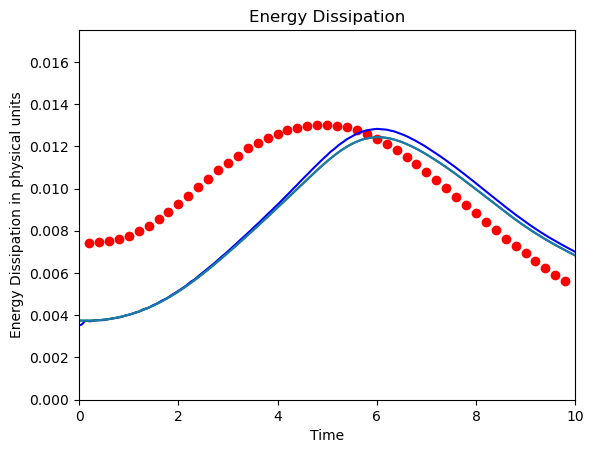

[31.00628281 30.97452354 30.94256592 30.90958786 30.87600899 30.84244537
 30.80901527 30.77554893 30.74193001 30.7081337  30.6742382  30.64032364
 30.60644913 30.57259369 30.53865814 30.50457954 30.4703598  30.43602371
 30.40158463 30.36700439 30.33225822 30.2973671  30.26237106 30.22728348
 30.19199944 30.15641785 30.12056541 30.08452988 30.0483799  30.01201439
 29.97533989 29.93837357 29.90120697 29.86386871 29.82623291 29.78816795
 29.74969673 29.71097374 29.67206192 29.63288498 29.59329224 29.55325317
 29.51284599 29.47212791 29.43103409 29.38947678 29.34745789 29.30506706
 29.26233292 29.21919441 29.17556    29.13139915 29.08673286 29.0416069
 28.99603271 28.94997025 28.90337753 28.85625458 28.80863571 28.76052666
 28.71186256 28.66255569 28.61260605 28.56212997 28.51118851 28.45970917
 28.40756607 28.35475922 28.30137634 28.24741173 28.19279671 28.13751411
 28.08160591 28.02509308 27.96796227 27.91018105 27.8517704  27.79268265
 27.73288345 27.672369   27.61120796 27.54944611 27.

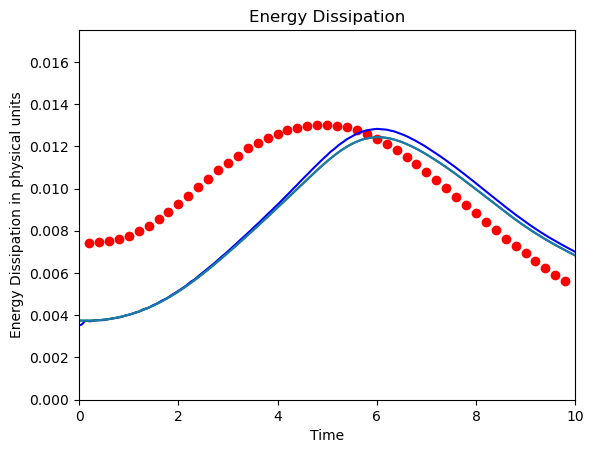

In [16]:
csv_file_path = '/home/ben/Schreibtisch/Enstropy Brachet/Brachet/Brachet_1983_tgv3d_enstrophy_Re100.csv'

# Date n aus der CSV-Datei lesen
csv_data = []
with open(csv_file_path, 'r') as file:
    csv_reader = csv.reader(file, delimiter=';')
    for row in csv_reader:
        csv_data.append(row)

csv_data = np.array(csv_data, dtype=float)
print(energy[:,2])
plt.plot(dissipationEkin[0,:],dissipationEkin[1,:],color = 'blue')
plt.plot(dissipationEns[0,:],dissipationEns[1,:], color = 'green')
plt.xlim(0,10)
plt.ylim(0,0.0175)
plt.plot(dissipationSij[0,:],dissipationSij[1,:])
plt.scatter(csv_data[:, 0], csv_data[:, 1], color='red', label='CSV Data')
plt.title('Energy Dissipation')
#plt.plot(energy[:,1],energy[:,2])
plt.xlabel('Time')
plt.ylabel('Energy Dissipation in physical units')
plt.show()



In [17]:
top_coords = sym_top[30,2:]
if isinstance(top_coords, torch.Tensor):
    top_coords_np = top_coords.cpu().numpy()  # In NumPy konvertieren
else:
    top_coords_np = np.array(top_coords)  # Falls es schon eine Liste ist

# Umwandlung in (N, 3) Form (falls noch 1D)
top_coords_np = top_coords_np.reshape(-1, 3)  # Jeder Satz aus 3 Werten entspricht (x, y, z)

# x-, y-, und z-Werte extrahieren
x, y, z = top_coords_np[:, 0], top_coords_np[:, 1], top_coords_np[:, 2]
print(x, y, z)

[16. 18. 18. ... 38. 23. 25.] [30. 31. 30. ...  7. 15. 31.] [ 2.  1.  2. ...  6. 38. 38.]
[16. 18. 18. ... 38. 23. 25.] [30. 31. 30. ...  7. 15. 31.] [ 2.  1.  2. ...  6. 38. 38.]


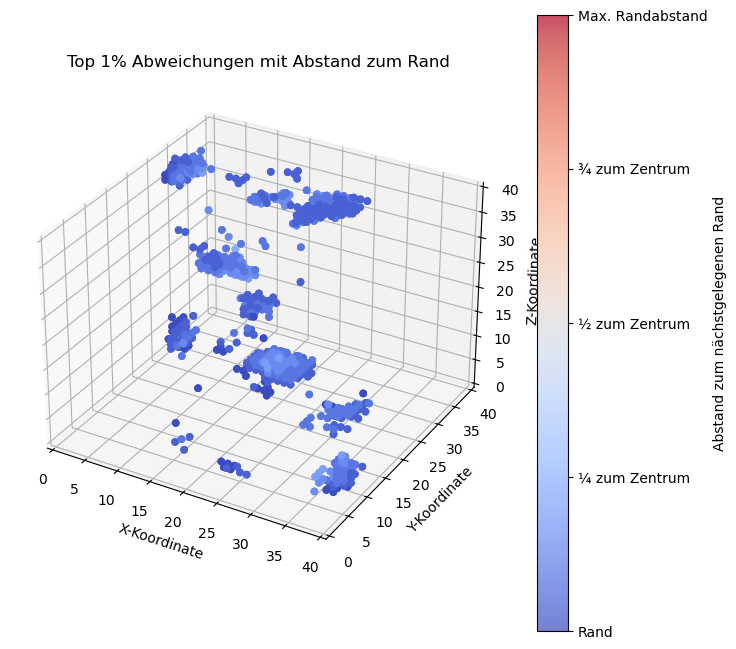

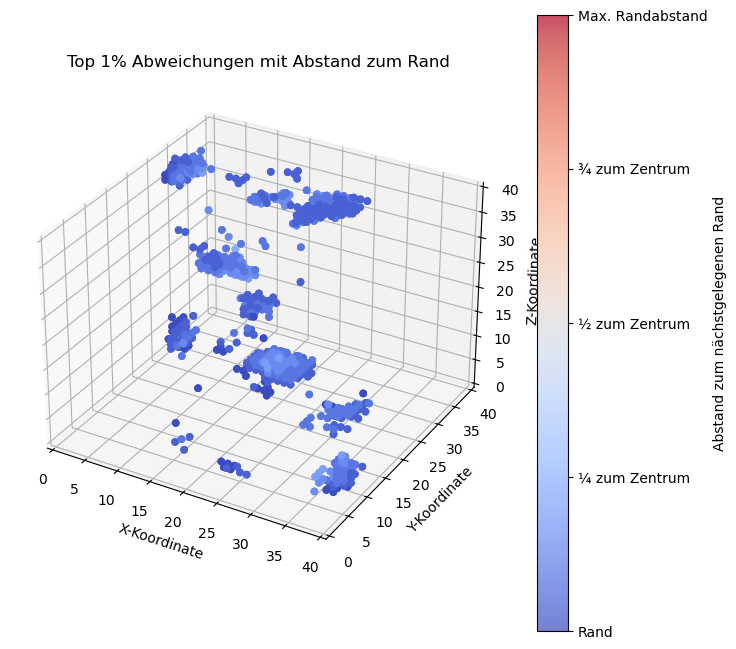

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Gittergröße
grid_size = res/2

# Falls `top_coords` ein Tensor ist, in NumPy-Array umwandeln
if isinstance(top_coords, torch.Tensor):
    top_coords_np = top_coords.cpu().numpy()
else:
    top_coords_np = np.array(top_coords)

# Umwandlung in (N,3)-Form, falls noch flach
top_coords_np = top_coords_np.reshape(-1, 3)

# Berechne den Abstand zum nächstgelegenen Rand
distances_to_edge = np.min([
    top_coords_np[:, 0],                   # Abstand zur x=0 Wand
    grid_size - top_coords_np[:, 0],        # Abstand zur x=N Wand
    top_coords_np[:, 1],                   # Abstand zur y=0 Wand
    grid_size - top_coords_np[:, 1],        # Abstand zur y=N Wand
    top_coords_np[:, 2],                   # Abstand zur z=0 Wand
    grid_size - top_coords_np[:, 2]         # Abstand zur z=N Wand
], axis=0)

# Maximal möglicher Rand-Abstand (Würfelmitte)
max_edge_distance = grid_size / 2

# 3D-Plot mit Farbskala nach Rand-Abstand
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(top_coords_np[:, 0], top_coords_np[:, 1], top_coords_np[:, 2],
                c=distances_to_edge, cmap='coolwarm', marker='o', alpha=0.7, vmin=0, vmax=max_edge_distance)

# Farblegende anpassen
cbar = plt.colorbar(sc, label="Abstand zum nächstgelegenen Rand")
cbar.set_ticks([0, max_edge_distance / 4, max_edge_distance / 2, 3 * max_edge_distance / 4, max_edge_distance])
cbar.set_ticklabels(["Rand", "¼ zum Zentrum", "½ zum Zentrum", "¾ zum Zentrum", "Max. Randabstand"])

# Achsentitel setzen
ax.set_xlabel("X-Koordinate")
ax.set_ylabel("Y-Koordinate")
ax.set_zlabel("Z-Koordinate")
ax.set_title("Top 1% Abweichungen mit Abstand zum Rand")

# Achsenlimits setzen
ax.set_xlim([0, grid_size])
ax.set_ylim([0, grid_size])
ax.set_zlim([0, grid_size])

plt.show()
